In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import numpy as np
import os
import pandas as pd
from tqdm import tqdm
import time
import collections
from sklearn.metrics.pairwise import cosine_similarity
import pickle

from scipy import stats
import numpy as np
import matplotlib.pyplot as plt
import cv2

%matplotlib inline

In [3]:
import gensim
from gensim.test.utils import common_texts
from gensim.models.doc2vec import Doc2Vec, TaggedDocument

In [4]:
data_dir = "/recsys_data/RecSys/h_and_m_personalized_fashion_recommendation"
df_prod = pd.read_csv(os.path.join(data_dir, "articles.csv"), dtype={'article_id': str, 'product_code': str})
df_prod = df_prod.set_index('article_id').T.to_dict()
print(f"Total {len(df_prod)} products")

Total 105542 products


In [5]:
df_prod['0108775015']

{'product_code': '0108775',
 'prod_name': 'Strap top',
 'product_type_no': 253,
 'product_type_name': 'Vest top',
 'product_group_name': 'Garment Upper body',
 'graphical_appearance_no': 1010016,
 'graphical_appearance_name': 'Solid',
 'colour_group_code': 9,
 'colour_group_name': 'Black',
 'perceived_colour_value_id': 4,
 'perceived_colour_value_name': 'Dark',
 'perceived_colour_master_id': 5,
 'perceived_colour_master_name': 'Black',
 'department_no': 1676,
 'department_name': 'Jersey Basic',
 'index_code': 'A',
 'index_name': 'Ladieswear',
 'index_group_no': 1,
 'index_group_name': 'Ladieswear',
 'section_no': 16,
 'section_name': 'Womens Everyday Basics',
 'garment_group_no': 1002,
 'garment_group_name': 'Jersey Basic',
 'detail_desc': 'Jersey top with narrow shoulder straps.'}

In [6]:
"""
{'product_code': '0108775',
 'prod_name': 'Strap top',
 'product_type_no': 253,
 'product_type_name': 'Vest top',
 'product_group_name': 'Garment Upper body',
 'graphical_appearance_no': 1010016,
 'graphical_appearance_name': 'Solid',
 'colour_group_code': 9,
 'colour_group_name': 'Black',
 'perceived_colour_value_id': 4,
 'perceived_colour_value_name': 'Dark',
 'perceived_colour_master_id': 5,
 'perceived_colour_master_name': 'Black',
 'department_no': 1676,
 'department_name': 'Jersey Basic',
 'index_code': 'A',
 'index_name': 'Ladieswear',
 'index_group_no': 1,
 'index_group_name': 'Ladieswear',
 'section_no': 16,
 'section_name': 'Womens Everyday Basics',
 'garment_group_no': 1002,
 'garment_group_name': 'Jersey Basic',
 'detail_desc': 'Jersey top with narrow shoulder straps.'}
"""
fields = ['prod_name', 'product_group_name', 'graphical_appearance_name', 
          'colour_group_name', 'index_name', 'section_name', 'detail_desc']
def read_corpus(prod_dict, tokens_only=False):
    for k in prod_dict.keys():
        text = ' '.join([str(prod_dict[k][f]) for f in fields])
        tokens = gensim.utils.simple_preprocess(text)
        if tokens_only:
            yield tokens
        else:
            # For training data, add tags
            yield gensim.models.doc2vec.TaggedDocument(tokens, [k])

train_corpus = list(read_corpus(df_prod))

In [7]:
print(train_corpus[:2])

[TaggedDocument(words=['strap', 'top', 'garment', 'upper', 'body', 'solid', 'black', 'ladieswear', 'womens', 'everyday', 'basics', 'jersey', 'top', 'with', 'narrow', 'shoulder', 'straps'], tags=['0108775015']), TaggedDocument(words=['strap', 'top', 'garment', 'upper', 'body', 'solid', 'white', 'ladieswear', 'womens', 'everyday', 'basics', 'jersey', 'top', 'with', 'narrow', 'shoulder', 'straps'], tags=['0108775044'])]


In [8]:
model = gensim.models.doc2vec.Doc2Vec(vector_size=50, min_count=2, epochs=40)
model.build_vocab(train_corpus)
model.train(train_corpus, total_examples=model.corpus_count, epochs=model.epochs)

In [9]:
# get all the product vectors and a separate list of product names
prod_vec = np.zeros((len(train_corpus), 50))
prod_list = [0 for _ in range(len(train_corpus))] 
for iid in tqdm(range(len(train_corpus))):
    inferred_vector = model.infer_vector(train_corpus[iid].words)
    prod_vec[iid] = inferred_vector
    doc_id = train_corpus[iid].tags[0]
    prod_list[iid] = doc_id

100%|██████████| 105542/105542 [07:22<00:00, 238.25it/s]


In [10]:
prod_list[:10]

['0108775015',
 '0108775044',
 '0108775051',
 '0110065001',
 '0110065002',
 '0110065011',
 '0111565001',
 '0111565003',
 '0111586001',
 '0111593001']

### Write the product vectors in a file

In [11]:
out_file = os.path.join(data_dir, "prod_vectors.pkl")
with open(out_file, "wb") as fw:
    pickle.dump((prod_vec, prod_list), fw)
    
print(prod_vec.shape, len(prod_list))

## Find Product Similarity

In [ ]:
# this will not work because of the size
# dist_matrix = cosine_similarity(prod_vec, prod_vec)

In [131]:
batch = 256
N = prod_vec.shape[0]
num_steps = N//batch
max_keep = 10
similar_items = np.zeros((len(train_corpus), max_keep))
start, end = 0, batch
for ii in tqdm(range(num_steps+1)):
    x = prod_vec[start:end,:]
    dist_matrix = cosine_similarity(x, prod_vec)
    indices = np.argsort(dist_matrix, axis=-1)[:,-(max_keep+1):-1]
    similar_items[start:end,:] = indices
    
    start += batch
    end += batch
    if end > N:
        end = N

#     s2, e2 = 0, batch
#     for jj in range(num_steps+1):
#         y = prod_vec[s2:e2,:]
#         dist_matrix = cosine_similarity(x, y)
        
#         # indices of the most similar ones
#         indices = np.argsort(dist_matrix, axis=-1)[:,-(max_keep+1):-1]
        
similar_items = np.fliplr(similar_items)

100%|██████████| 413/413 [16:01<00:00,  2.33s/it]


Document-90000 (0840933002): «maxi pack garment lower body mixed solid pattern light yellow children sizes girls underwear basics length leggings in soft organic cotton jersey with covered elastication at the waist»

SIMILAR/DISSIMILAR DOCS PER MODEL Doc2Vec(dm/m,d50,n5,w5,mc2,s0.001,t3):

MOST 89999 (0840933001): «maxi pack garment lower body mixed solid pattern light orange children sizes girls underwear basics length leggings in soft organic cotton jersey with covered elastication at the waist»

SECOND-MOST 1855 (0379360043): «maxi pack garment lower body solid light pink children sizes girls underwear basics length leggings in soft organic cotton jersey with an elasticated waist»

MEDIAN 52904 (0702726004): «maxi pack garment lower body mixed solid pattern dark blue children sizes girls underwear basics length leggings in soft organic cotton jersey with an elasticated waist»

LEAST 1852 (0379360033): «maxi pack garment lower body solid white children sizes girls underwear basics le

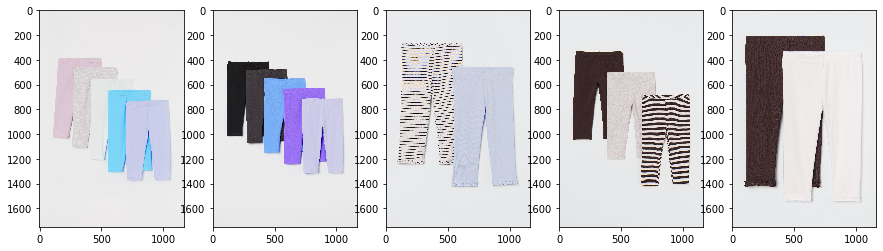

In [177]:
doc_id = 90000
img_folder = "/recsys_data/RecSys/h_and_m_personalized_fashion_recommendation/images"
pid = train_corpus[doc_id].tags[0]
img_file_path = os.path.join(img_folder, pid[:3], pid+".jpg")
img = cv2.imread(img_file_path)
plt.subplots(1,5, figsize=(15,5))
plt.subplot(1, 5, 1)
plt.imshow(img)

print('Document-{} ({}): «{}»\n'.format(doc_id, pid, ' '.join(train_corpus[doc_id].words)))
print(u'SIMILAR/DISSIMILAR DOCS PER MODEL %s:\n' % model)
sims = similar_items[doc_id]
sims = sims.astype(int)
count = 2
for label, index in [('MOST', 0), ('SECOND-MOST', 1), ('MEDIAN', len(sims)//2), ('LEAST', len(sims) - 1)]:
    pid = train_corpus[sims[index]].tags[0]
    print(u'%s %s (%s): «%s»\n' % (label, sims[index], pid, ' '.join(train_corpus[sims[index]].words)))
    img_file_path = os.path.join(img_folder, pid[:3], pid+".jpg")
    img = cv2.imread(img_file_path)
    plt.subplot(1, 5, count)
    plt.imshow(img)
    count += 1


In [105]:
def max_heapify(A, i):

    # modified due to 0-index
    def left(i):
        return 2 * (i+1) - 1
    
    def right(i):
        return 2 * (i+1)
    
    l = left(i)
    r = right(i)
    
    # and short-circuits
    if l < heap_size and A[l] > A[i]:
        largest = l
    else:
        largest = i
    if r < heap_size and A[r] > A[largest]:
        largest = r
    if largest != i:
        temp = A[i]
        A[i] = A[largest]
        A[largest] = temp
        max_heapify(A, largest)
    return A
        

In [106]:
# A = [4, 10, 3, 5, 1]
A = [1, 3, 5, 4, 6, 13, 10, 9, 8, 15, 17]
heap_size = len(A)
for ii in range(len(A)//2, -1, -1):
    A = max_heapify(A, ii)
print(A)

[17, 15, 13, 9, 6, 5, 10, 4, 8, 3, 1]
